# Stellargraph example: GraphSAGE on the CORA citation network

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector import neo4j
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
import py2neo
import numpy as np
%load_ext autoreload
%autoreload 2

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

In [2]:
def get_node_data_from_neo4j(scheme, host, username, password):
    
    neo4j_graphdb = py2neo.Graph(scheme=scheme, host=host, auth=(username, password))
    
    fetch_node_query = "MATCH (node) RETURN id(node), properties(node)"

    #run the node-fetching query
    node_records = neo4j_graphdb.run(fetch_node_query)

    #convert the node records into pandas dataframe
    return pd.DataFrame(node_records).rename(columns = {0:'id', 1:'attr'})

start = time.time()
node_df = get_node_data_from_neo4j(scheme="bolt", host="localhost", username="neo4j", password="cora")
end = time.time()

print(f"{end - start} s: Loading all vertices from neo4j database to memory")
node_df.head(5)

2.2312750816345215 s: Loading all vertices from neo4j database to memory


,id,attr
0,0,"{'features': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,"{'features': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"{'features': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"{'features': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,4,"{'features': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [3]:
attr_df = node_df['attr'].apply(pd.Series).drop(labels = ['id'], axis = 1)
node_df = pd.concat([node_df['id'], attr_df], axis = 1) #.sort_values(by='id', ascending = True)
node_df = node_df.set_index('id')

feats_df = pd.DataFrame(node_df['features'].values.tolist(), index=node_df.index)
feats_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels = np.array(node_df['subject'])

target_encoding = preprocessing.OneHotEncoder(sparse=False, categories='auto')
targets = target_encoding.fit_transform(labels.reshape(-1, 1))
targets = pd.DataFrame(targets, index=node_df.index)

In [5]:
Gnx = nx.Graph()
Gnx.add_nodes_from(node_df.index, label = 'paper')

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [6]:
set(node_df["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [7]:
train_data, test_data = model_selection.train_test_split(node_df, train_size=0.1, test_size=None, stratify=node_df['subject'])

Note using stratified sampling gives the following counts:

In [8]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 81,
         'Probabilistic_Methods': 42,
         'Theory': 35,
         'Case_Based': 30,
         'Genetic_Algorithms': 42,
         'Reinforcement_Learning': 22,
         'Rule_Learning': 18})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [9]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [10]:
node_features = feats_df
train_targets

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [11]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [12]:
print(G.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 0

 Node types:
  paper: [2708]
    Edge types: 

 Edge types:



To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [13]:
batch_size = 50; num_samples = [5,5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [14]:
neo4j_graphdb = py2neo.Graph("http://localhost:7474", auth=('neo4j', 'cora'))
generator = neo4j.Neo4JGraphSAGENodeGenerator(G, batch_size, num_samples, neo4j_graphdb)

In [15]:
print(generator.sample_features([3276]))

[array([], shape=(1, 0, 1433), dtype=float64), array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]


Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [16]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [17]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=generator,
    bias=True,
    dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [18]:
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [19]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [20]:
test_gen = generator.flow(test_data.index, test_targets)

In [21]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    verbose=2,
    shuffle=False
)

Epoch 1/20
6/6 - 2s - loss: 1.8845 - acc: 0.2407 - val_loss: 1.7324 - val_acc: 0.3056
Epoch 2/20
6/6 - 2s - loss: 1.6949 - acc: 0.3667 - val_loss: 1.6111 - val_acc: 0.3421
Epoch 3/20
6/6 - 2s - loss: 1.5054 - acc: 0.5111 - val_loss: 1.4372 - val_acc: 0.5656
Epoch 4/20
6/6 - 2s - loss: 1.3630 - acc: 0.7444 - val_loss: 1.3110 - val_acc: 0.7190
Epoch 5/20
6/6 - 2s - loss: 1.2384 - acc: 0.8407 - val_loss: 1.2148 - val_acc: 0.7203
Epoch 6/20
6/6 - 2s - loss: 1.1173 - acc: 0.8259 - val_loss: 1.1274 - val_acc: 0.7375
Epoch 7/20
6/6 - 2s - loss: 1.0068 - acc: 0.8741 - val_loss: 1.0396 - val_acc: 0.7744
Epoch 8/20
6/6 - 2s - loss: 0.8987 - acc: 0.9222 - val_loss: 0.9802 - val_acc: 0.7888
Epoch 9/20
6/6 - 2s - loss: 0.8297 - acc: 0.9222 - val_loss: 0.9338 - val_acc: 0.7998
Epoch 10/20
6/6 - 2s - loss: 0.7470 - acc: 0.9444 - val_loss: 0.8878 - val_acc: 0.7974
Epoch 11/20
6/6 - 2s - loss: 0.6789 - acc: 0.9481 - val_loss: 0.8550 - val_acc: 0.7990
Epoch 12/20
6/6 - 2s - loss: 0.6124 - acc: 0.9481 - 

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

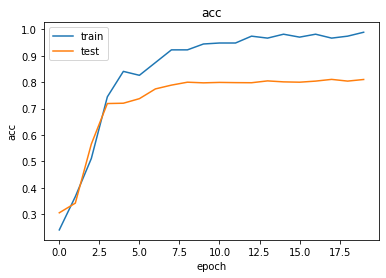

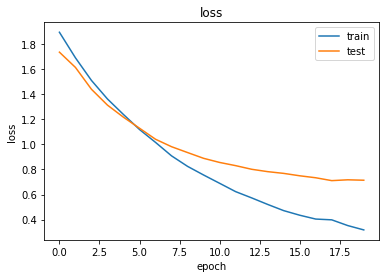

In [24]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [25]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.6991
	acc: 0.8130


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [26]:
all_nodes = node_df.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [27]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [28]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_df['subject']})
df.head(10)

,Predicted,True
id,,
0,subject=Theory,Neural_Networks
1,subject=Rule_Learning,Rule_Learning
2,subject=Reinforcement_Learning,Reinforcement_Learning
3,subject=Reinforcement_Learning,Reinforcement_Learning
4,subject=Probabilistic_Methods,Probabilistic_Methods
5,subject=Probabilistic_Methods,Probabilistic_Methods
6,subject=Reinforcement_Learning,Theory
7,subject=Theory,Neural_Networks
8,subject=Theory,Neural_Networks


Add the predictions to the graph, and save as graphml, e.g. for visualisation in [Gephi](https://gephi.org)

In [29]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

Also add isTrain and isCorrect node attributes:

In [30]:
for nid in train_data.index:
    Gnx.nodes[nid]["isTrain"] = True
    
for nid in test_data.index:
    Gnx.nodes[nid]["isTrain"] = False

In [31]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]

Save in GraphML format

In [32]:
data_dir = os.path.expanduser("data/cora")
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(data_dir,pred_fname))

FileNotFoundError: [Errno 2] No such file or directory: 'data/cora/pred_n=[5, 5].graphml'

## Node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict_generator(all_mapper)
emb.shape
print(emb)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
node_data[["subject"]].to_dict("records")

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)


In [ ]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()